# Model 1: predicting traffic accident severity with structured data

In this notebook we will be using various Machine Learning models in order to predict traffic accident severity.  The data is a combination of accident, population, and traffic data collected in the UK from 2013-2017. For this model we will be focusing on just accidents in London. 
Before modeling, we will further check and clean the data.

## Importing the libraries and data

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(123)
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, plot_importance, plot_tree
import itertools

In [2]:
accidents = pd.read_csv('data/accidents/London_accidents_merged.csv')

In [3]:
accidents.head()

,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,1st_Road_Class,Road_Type,Speed_limit,Junction_Detail,2nd_Road_Class,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Hour,Two_Hour_Groupings,Time_of_Day,Was_Daylight,Was_Bad_Weather,Was_Road_Dry,log_Number_of_Casualties,log_Number_of_Vehicles,LSOA,population_per_hectare,bicycle_aadf,motorbike_aadf,car_aadf,bus_aadf,light_goods_vehicle_aadf,heavy_goods_vehicle_aadf,Road,RCat
0,201301BS70003,-0.171402,51.486361,Serious,2,1,2013-01-02,Wednesday,A,Single carriageway,30.0,T or staggered junction,Unclassified,Daylight,Fine no high winds,Dry,Urban,9,8am-10am,Morning,Yes,No,Yes,0.000000,0.693147,E01002844,110.8,1634.4,860.4,14888.0,1139.8,2297.0,352.0,A3217,PA
1,201301BS70005,-0.173356,51.495115,Slight,1,2,2013-01-04,Friday,A,Single carriageway,30.0,Crossroads,A,Daylight,Other,Dry,Urban,8,8am-10am,Morning,Yes,Yes,Yes,0.693147,0.000000,E01002821,74.6,559.6,1516.0,28505.6,1396.2,3868.6,1003.0,A4,PA
2,201301BS70006,-0.210767,51.518353,Slight,1,1,2013-01-07,Monday,B,Single carriageway,30.0,Crossroads,B,Daylight,Fine no high winds,Dry,Urban,11,10am-12pm,Office hours,Yes,No,Yes,0.000000,0.000000,E01002878,133.4,2.6,3898.2,63274.8,763.4,15253.6,3185.8,A40,PA
3,201301BS70007,-0.209675,51.516808,Slight,2,1,2013-01-10,Thursday,B,Single carriageway,30.0,Crossroads,C,Daylight,Fine no high winds,Dry,Urban,10,10am-12pm,Office hours,Yes,No,Yes,0.000000,0.693147,E01002831,179.2,2.6,3898.2,63274.8,763.4,15253.6,3185.8,A40,PA
4,201301BS70009,-0.194332,51.492922,Slight,2,1,2013-01-04,Friday,A,One way street,30.0,T or staggered junction,Unclassified,Darkness - lights lit,Fine no high winds,Dry,Urban,17,4pm-6pm,Rush hour,No,No,Yes,0.000000,0.693147,E01002851,272.3,869.2,1229.8,20478.6,897.2,4951.6,1251.4,A3220,PA


## Preparing the data for modelling

In [4]:
# Adding a column for month
accidents['Month'] = pd.to_datetime(accidents['Date']).dt.month_name()

In [5]:
# Dropping unnecessary columns
accidents.drop(['Accident_Index', 'Longitude', 'Latitude', 'Number_of_Vehicles', 'Number_of_Casualties', 
                'Date', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Hour', 
                'Time_of_Day', 'log_Number_of_Casualties', 'log_Number_of_Vehicles', 'LSOA', 'Road', 'RCat'], 
               axis=1, inplace=True)

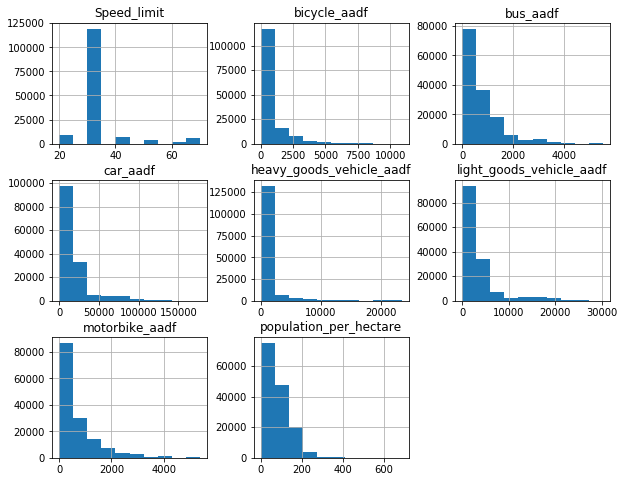

In [6]:
# Checking whether numerical columns need log transforming
accidents.hist(figsize=(10,8));

In [7]:
# Log-transforming traffic and population counts due to positive skew
# Creating list of columns to transform
to_log_transform = list(accidents.columns[accidents.columns.str.endswith('aadf') == True])
to_log_transform.append('population_per_hectare')

# Replacing 0s with 0.1s to allow for log transformation
accidents[to_log_transform] = accidents[to_log_transform].replace(0, 0.1)

# Adding log transformed columns and dropping original columns
for col in to_log_transform:
    log_col = "log_"+col
    accidents[log_col] = np.log(accidents[col])
    accidents.drop(col, axis=1, inplace=True)

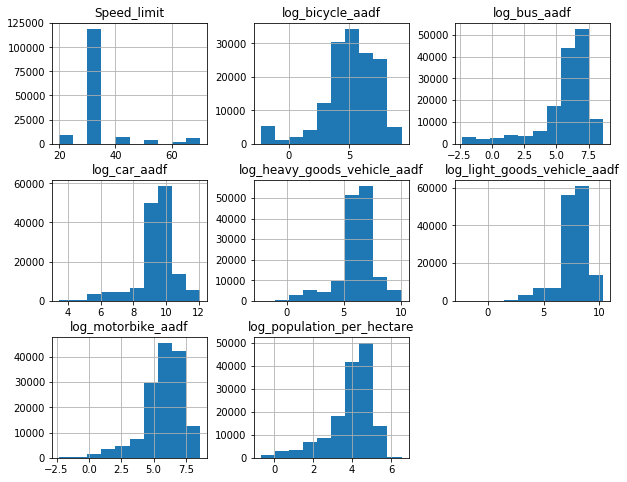

In [8]:
# Confirming that distributions are now more normal
accidents.hist(figsize=(10,8));

In [9]:
# Converting the target variable into numeric categories
accidents['Accident_Severity'].replace({'Slight': 1, 'Serious': 2, 'Fatal': 3}, inplace=True)
accidents['Accident_Severity'] = accidents['Accident_Severity'].astype('int64')

In [10]:
# One-hot encoding categorical variables
transformed_df = pd.get_dummies(accidents, drop_first=True)

In [11]:
def multi_collinearity_heatmap(df, figsize=(11,9), annot=False):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, annot=annot, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

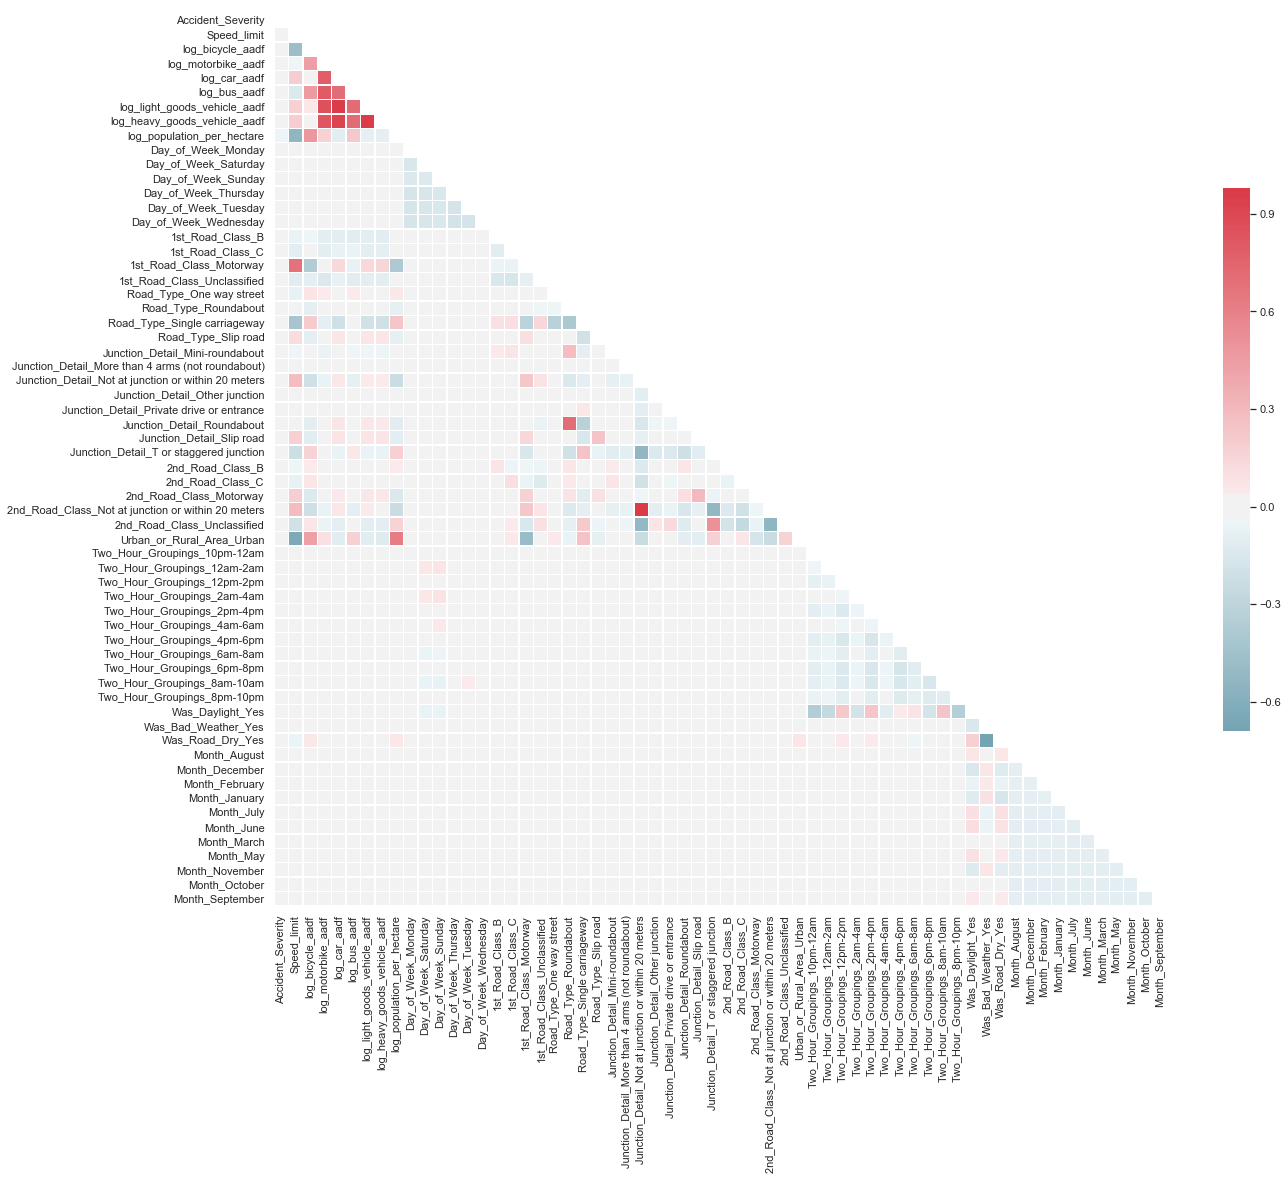

In [12]:
# Checking for multi-collinearity
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

Other columns to be dropped based on the multi-collinearity heatmap above:
- No junction within 20 metres is recorded under both '2nd_Road_Class' and 'Junction_Detail', so one will be dropped
- Roundabouts are recorded under both 'Road_Type' and 'Junction_Detail', so one will be dropped
- There is high correlation between traffic counts of motorbikes, cars, buses, light goods vehicles and heavy goods vehicles, so these can be combined into one feature

In [13]:
# Dropping columns
transformed_df.drop(['2nd_Road_Class_Not at junction or within 20 meters', 'Road_Type_Roundabout'], axis=1, inplace=True)

In [14]:
# Combining columns by undoing the log transformation, summing and then re-doing it
transformed_df['log_motor_vehicle_aadf'] = np.log(np.exp(transformed_df['log_motorbike_aadf'])
    + np.exp(transformed_df['log_car_aadf'])
    + np.exp(transformed_df['log_bus_aadf'])
    + np.exp(transformed_df['log_light_goods_vehicle_aadf'])
    + np.exp(transformed_df['log_heavy_goods_vehicle_aadf']))

In [15]:
# Dropping the columns that have now been combined
transformed_df.drop(['log_motorbike_aadf', 'log_car_aadf', 'log_bus_aadf', 'log_light_goods_vehicle_aadf', 'log_heavy_goods_vehicle_aadf'], axis=1, inplace=True)

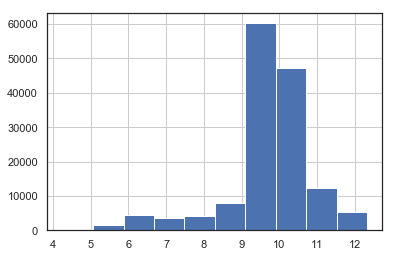

In [16]:
# Checking that the new column is roughly normally distributed
transformed_df.log_motor_vehicle_aadf.hist();

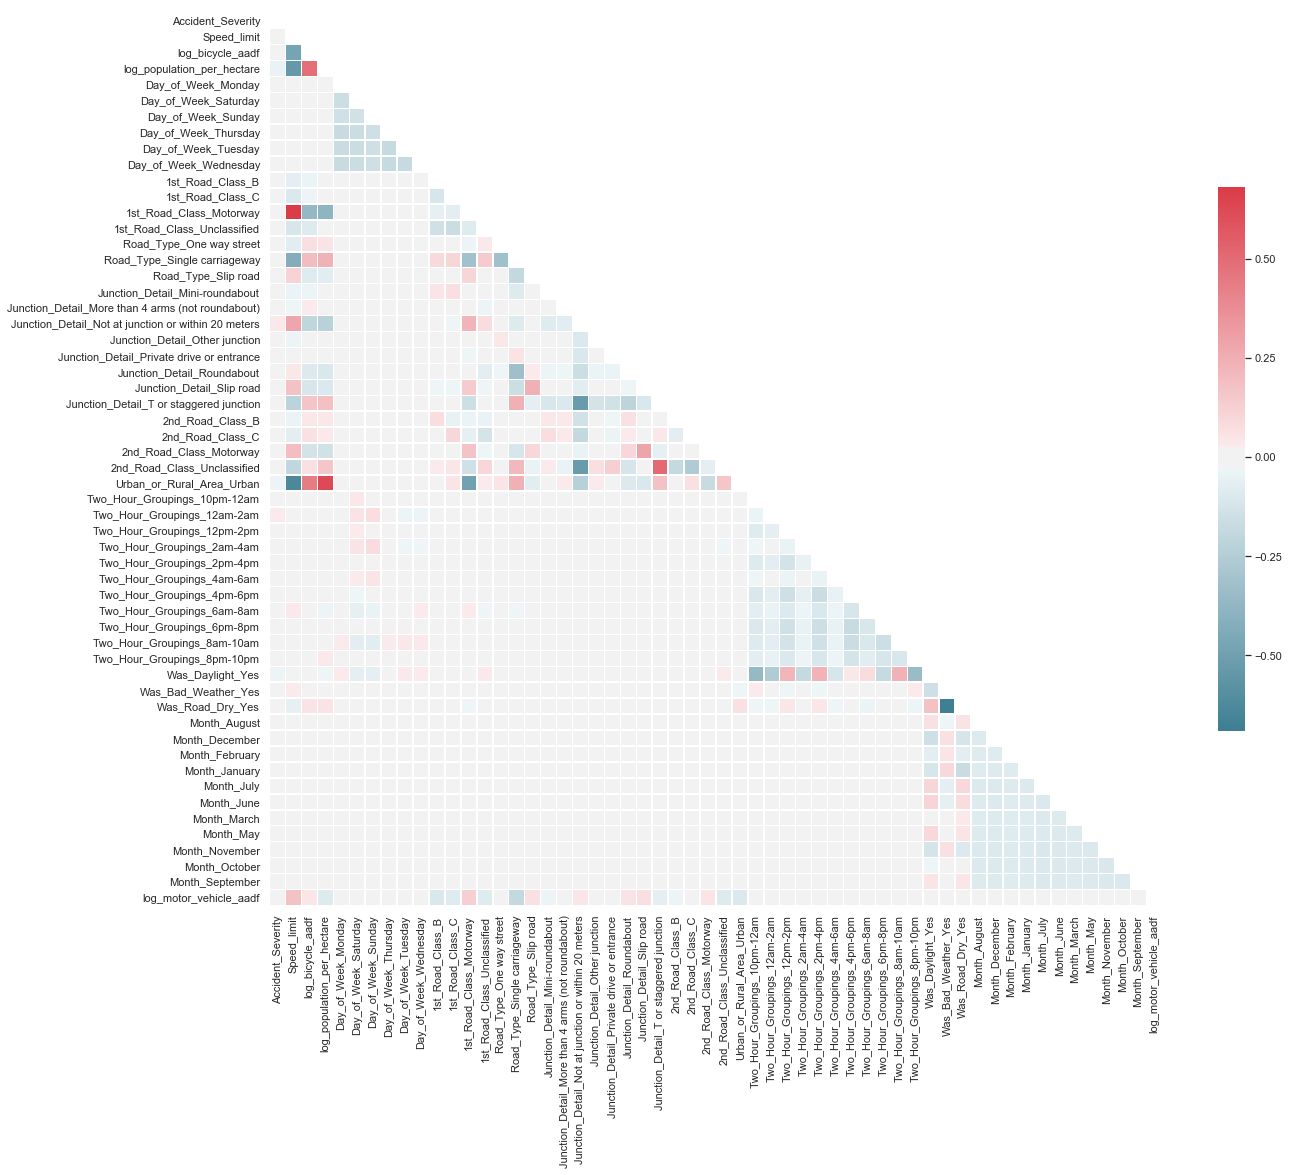

In [17]:
# Final check for multi-collinearity
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

A few notable correlations remain which make sense, e.g. a negative correlation between bad weather and dry roads, and positive correlations between urban areas and high population density, and motorways and speed limits. These could potentially be removed in later iterations of the model, but the correlations are not too high to require removal.

### Split and Scale Data for Modeling

In [18]:
# Check target variable
transformed_df.Accident_Severity.value_counts(normalize=True)

1    0.894322
2    0.100171
3    0.005507
Name: Accident_Severity, dtype: float64

Since there are very few fatal accidents, will combine serious and fatal accidents into one class and make this a binary classification problem.

In [19]:
# Separating X and y and combining serious and fatal accidents
# 0: serious/fatal, 1: slight or in other words
# 0: major, 1: minor
X = transformed_df.drop('Accident_Severity', axis=1)
y = transformed_df['Accident_Severity']
y = y.replace([2,3], [0,0])

In [20]:
# Splitting the data into train and test sets (automatically uses stratified sampling by labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [21]:
# Scaling X using StandardScaler
# Only fit training data to avoid data leakage
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=list(X_train.columns))
X_test = pd.DataFrame(scaler.transform(X_test), columns=list(X_test.columns))
X_train.head()

/Users/sabatinochen/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/sabatinochen/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/sabatinochen/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  """


,Speed_limit,log_bicycle_aadf,log_population_per_hectare,Day_of_Week_Monday,Day_of_Week_Saturday,Day_of_Week_Sunday,Day_of_Week_Thursday,Day_of_Week_Tuesday,Day_of_Week_Wednesday,1st_Road_Class_B,1st_Road_Class_C,1st_Road_Class_Motorway,1st_Road_Class_Unclassified,Road_Type_One way street,Road_Type_Single carriageway,Road_Type_Slip road,Junction_Detail_Mini-roundabout,Junction_Detail_More than 4 arms (not roundabout),Junction_Detail_Not at junction or within 20 meters,Junction_Detail_Other junction,Junction_Detail_Private drive or entrance,Junction_Detail_Roundabout,Junction_Detail_Slip road,Junction_Detail_T or staggered junction,2nd_Road_Class_B,...,Two_Hour_Groupings_12am-2am,Two_Hour_Groupings_12pm-2pm,Two_Hour_Groupings_2am-4am,Two_Hour_Groupings_2pm-4pm,Two_Hour_Groupings_4am-6am,Two_Hour_Groupings_4pm-6pm,Two_Hour_Groupings_6am-8am,Two_Hour_Groupings_6pm-8pm,Two_Hour_Groupings_8am-10am,Two_Hour_Groupings_8pm-10pm,Was_Daylight_Yes,Was_Bad_Weather_Yes,Was_Road_Dry_Yes,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,log_motor_vehicle_aadf
0,-0.244613,-1.000123,-0.061492,2.469861,-0.387282,-0.346434,-0.426525,-0.42157,-0.427059,-0.314826,-0.359186,-0.181469,2.195634,-0.185062,0.579262,-0.10971,-0.1311,-0.118789,1.585570,-0.158095,-0.161938,-0.253174,-0.125777,-0.837753,-0.21615,...,-0.171193,-0.346598,-0.127035,-0.379662,-0.123072,-0.427504,-0.270703,-0.405821,2.651854,-0.290828,0.654190,-0.382906,0.488269,-0.292621,-0.296908,-0.275646,-0.291213,3.141940,-0.307819,-0.294606,-0.304720,-0.321271,-0.319207,-0.304045,-2.464241
1,-0.244613,1.093502,1.115207,-0.404881,-0.387282,2.886556,-0.426525,-0.42157,-0.427059,-0.314826,-0.359186,-0.181469,-0.455449,-0.185062,0.579262,-0.10971,-0.1311,-0.118789,-0.630688,-0.158095,-0.161938,-0.253174,-0.125777,1.193670,-0.21615,...,-0.171193,-0.346598,-0.127035,-0.379662,-0.123072,-0.427504,-0.270703,-0.405821,-0.377095,3.438454,-1.528607,-0.382906,0.488269,-0.292621,-0.296908,-0.275646,-0.291213,-0.318275,-0.307819,-0.294606,3.281699,-0.321271,-0.319207,-0.304045,0.356620
2,-0.244613,1.113664,0.782311,-0.404881,-0.387282,2.886556,-0.426525,-0.42157,-0.427059,-0.314826,2.784075,-0.181469,-0.455449,-0.185062,0.579262,-0.10971,-0.1311,-0.118789,-0.630688,-0.158095,-0.161938,-0.253174,-0.125777,-0.837753,-0.21615,...,-0.171193,-0.346598,-0.127035,-0.379662,-0.123072,-0.427504,-0.270703,2.464141,-0.377095,-0.290828,-1.528607,-0.382906,-2.048052,-0.292621,-0.296908,-0.275646,3.433911,-0.318275,-0.307819,-0.294606,-0.304720,-0.321271,-0.319207,-0.304045,-0.111605
3,-0.244613,0.504987,0.818145,-0.404881,-0.387282,-0.346434,-0.426525,-0.42157,2.341597,-0.314826,-0.359186,-0.181469,2.195634,-0.185062,0.579262,-0.10971,-0.1311,-0.118789,-0.630688,-0.158095,-0.161938,-0.253174,-0.125777,1.193670,-0.21615,...,-0.171193,2.885189,-0.127035,-0.379662,-0.123072,-0.427504,-0.270703,-0.405821,-0.377095,-0.290828,0.654190,-0.382906,0.488269,-0.292621,-0.296908,-0.275646,-0.291213,-0.318275,-0.307819,-0.294606,-0.304720,-0.321271,-0.319207,3.288991,0.326695
4,-0.244613,0.164980,-0.129147,-0.404881,-0.387282,-0.346434,-0.426525,-0.42157,2.341597,-0.314826,-0.359186,-0.181469,-0.455449,-0.185062,-1.726334,-0.10971,-0.1311,-0.118789,-0.630688,-0.158095,-0.161938,-0.253174,-0.125777,1.193670,-0.21615,...,-0.171193,-0.346598,-0.127035,-0.379662,-0.123072,-0.427504,-0.270703,-0.405821,2.651854,-0.290828,0.654190,-0.382906,0.488269,3.417388,-0.296908,-0.275646,-0.291213,-0.318275,-0.307819,-0.294606,-0.304720,-0.321271,-0.319207,-0.304045,0.196121


## Modelling

### Model iteration 1: Logistic Regression
For our first model in predicing major versus minor accidents will use a simple logistic regression model.

In [22]:
lr = LogisticRegression(solver='liblinear', random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [23]:
print("Train:", lr.score(X_train, y_train))
print("Test:", lr.score(X_test, y_test))

lr_y_preds_train = lr.predict(X_train)
print(classification_report(y_train, lr_y_preds_train, target_names=['major', 'minor']))

lr_y_preds_test = lr.predict(X_test)
print(classification_report(y_test, lr_y_preds_test, target_names=['major', 'minor']))

Train: 0.8941132745929874
Test: 0.8949500992576075


/Users/sabatinochen/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sabatinochen/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sabatinochen/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sabatinochen/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score a

              precision    recall  f1-score   support

       major       0.00      0.00      0.00     11681
       minor       0.89      1.00      0.94     98635

   micro avg       0.89      0.89      0.89    110316
   macro avg       0.45      0.50      0.47    110316
weighted avg       0.80      0.89      0.84    110316

              precision    recall  f1-score   support

       major       0.00      0.00      0.00      3863
       minor       0.89      1.00      0.94     32910

   micro avg       0.89      0.89      0.89     36773
   macro avg       0.45      0.50      0.47     36773
weighted avg       0.80      0.89      0.85     36773



/Users/sabatinochen/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sabatinochen/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


These results are misleading. Since our dataset is heavily imbalanced, accuracy is not a good metric to use. Below you will see from the confusion matrix that the model learns to just always predict the majority class, thus scoring an accuracy score equal to the percentage of majority class there is in the dataset.

In [26]:
def plot_cf(y_true, y_pred, class_names=None, model_name=None):
    """Plots a confusion matrix"""
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    #class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

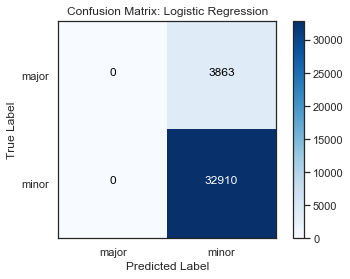

In [25]:
plot_cf(y_test, lr_y_preds_test, model_name='Logistic Regression', class_names=['major', 'minor'])

These results are not ideal, in order to help with this accuracy paradox and imbalanced dataset, we will use upsampling on the minority class and try to improve other metrics that are more meaningful than accuracy in this scenario such as precision, recall, and F1.

### Model iteration 2: Logistic Regression with upsampling

In [26]:
# Splitting the data into train and test sets (automatically uses stratified sampling by labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

# concatenate our training data back together
training_data = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_safe = training_data[training_data.Accident_Severity==0]
safe = training_data[training_data.Accident_Severity==1]

# upsample minority
not_safe_upsampled = resample(not_safe,
                          replace=True, # sample with replacement
                          n_samples=len(safe), # match number in majority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([safe, not_safe_upsampled])

# check new class counts
print(upsampled.Accident_Severity.value_counts())

X_train = upsampled.drop('Accident_Severity', axis=1)
y_train = upsampled.Accident_Severity

# Scaling X using StandardScaler
# Only fit training data to avoid data leakage
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=list(X.columns))
X_test = pd.DataFrame(scaler.transform(X_test), columns=list(X.columns))
X_train.head()

1    98635
0    98635
Name: Accident_Severity, dtype: int64


/Users/sabatinochen/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/sabatinochen/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/sabatinochen/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.


,Speed_limit,log_bicycle_aadf,log_population_per_hectare,Day_of_Week_Monday,Day_of_Week_Saturday,Day_of_Week_Sunday,Day_of_Week_Thursday,Day_of_Week_Tuesday,Day_of_Week_Wednesday,1st_Road_Class_B,1st_Road_Class_C,1st_Road_Class_Motorway,1st_Road_Class_Unclassified,Road_Type_One way street,Road_Type_Single carriageway,Road_Type_Slip road,Junction_Detail_Mini-roundabout,Junction_Detail_More than 4 arms (not roundabout),Junction_Detail_Not at junction or within 20 meters,Junction_Detail_Other junction,Junction_Detail_Private drive or entrance,Junction_Detail_Roundabout,Junction_Detail_Slip road,Junction_Detail_T or staggered junction,2nd_Road_Class_B,...,Two_Hour_Groupings_12am-2am,Two_Hour_Groupings_12pm-2pm,Two_Hour_Groupings_2am-4am,Two_Hour_Groupings_2pm-4pm,Two_Hour_Groupings_4am-6am,Two_Hour_Groupings_4pm-6pm,Two_Hour_Groupings_6am-8am,Two_Hour_Groupings_6pm-8pm,Two_Hour_Groupings_8am-10am,Two_Hour_Groupings_8pm-10pm,Was_Daylight_Yes,Was_Bad_Weather_Yes,Was_Road_Dry_Yes,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,log_motor_vehicle_aadf
0,-0.255871,-0.973295,-0.009278,2.493978,-0.393215,-0.353309,-0.420556,-0.417622,-0.423756,-0.319585,-0.357480,-0.18264,2.170221,-0.189465,0.577323,-0.10502,-0.123042,-0.117179,1.521536,-0.163775,-0.160847,-0.238462,-0.123508,-0.833252,-0.213071,...,-0.188155,-0.339634,-0.139431,-0.368783,-0.133594,-0.423132,-0.277523,-0.404706,2.720592,-0.292444,0.685807,-0.381654,0.491176,-0.287813,-0.300689,-0.273968,-0.291217,3.138335,-0.307266,-0.29652,-0.305583,-0.325219,-0.318775,-0.301209,-2.439811
1,-0.255871,1.084867,1.115316,-0.400966,-0.393215,2.830381,-0.420556,-0.417622,-0.423756,-0.319585,-0.357480,-0.18264,-0.460782,-0.189465,0.577323,-0.10502,-0.123042,-0.117179,-0.657231,-0.163775,-0.160847,-0.238462,-0.123508,1.200118,-0.213071,...,-0.188155,-0.339634,-0.139431,-0.368783,-0.133594,-0.423132,-0.277523,-0.404706,-0.367567,3.419460,-1.458135,-0.381654,0.491176,-0.287813,-0.300689,-0.273968,-0.291217,-0.318640,-0.307266,-0.29652,3.272432,-0.325219,-0.318775,-0.301209,0.362447
2,-0.255871,1.104687,0.797161,-0.400966,-0.393215,2.830381,-0.420556,-0.417622,-0.423756,-0.319585,2.797358,-0.18264,-0.460782,-0.189465,0.577323,-0.10502,-0.123042,-0.117179,-0.657231,-0.163775,-0.160847,-0.238462,-0.123508,-0.833252,-0.213071,...,-0.188155,-0.339634,-0.139431,-0.368783,-0.133594,-0.423132,-0.277523,2.470931,-0.367567,-0.292444,-1.458135,-0.381654,-2.035930,-0.287813,-0.300689,-0.273968,3.433871,-0.318640,-0.307266,-0.29652,-0.305583,-0.325219,-0.318775,-0.301209,-0.102691
3,-0.255871,0.506321,0.831409,-0.400966,-0.393215,-0.353309,-0.420556,-0.417622,2.359847,-0.319585,-0.357480,-0.18264,2.170221,-0.189465,0.577323,-0.10502,-0.123042,-0.117179,-0.657231,-0.163775,-0.160847,-0.238462,-0.123508,1.200118,-0.213071,...,-0.188155,2.944342,-0.139431,-0.368783,-0.133594,-0.423132,-0.277523,-0.404706,-0.367567,-0.292444,0.685807,-0.381654,0.491176,-0.287813,-0.300689,-0.273968,-0.291217,-0.318640,-0.307266,-0.29652,-0.305583,-0.325219,-0.318775,3.319949,0.332719
4,-0.255871,0.172072,-0.073937,-0.400966,-0.393215,-0.353309,-0.420556,-0.417622,2.359847,-0.319585,-0.357480,-0.18264,-0.460782,-0.189465,-1.732133,-0.10502,-0.123042,-0.117179,-0.657231,-0.163775,-0.160847,-0.238462,-0.123508,1.200118,-0.213071,...,-0.188155,-0.339634,-0.139431,-0.368783,-0.133594,-0.423132,-0.277523,-0.404706,2.720592,-0.292444,0.685807,-0.381654,0.491176,3.474483,-0.300689,-0.273968,-0.291217,-0.318640,-0.307266,-0.29652,-0.305583,-0.325219,-0.318775,-0.301209,0.203006


Train: 0.5511583109443909
Test: 0.598808908710195
              precision    recall  f1-score   support

       major       0.56      0.49      0.52     98635
       minor       0.55      0.61      0.58     98635

   micro avg       0.55      0.55      0.55    197270
   macro avg       0.55      0.55      0.55    197270
weighted avg       0.55      0.55      0.55    197270

              precision    recall  f1-score   support

       major       0.13      0.47      0.20      3863
       minor       0.91      0.61      0.73     32910

   micro avg       0.60      0.60      0.60     36773
   macro avg       0.52      0.54      0.47     36773
weighted avg       0.83      0.60      0.68     36773



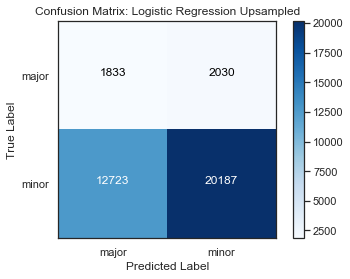

In [27]:
lr2 = LogisticRegression(solver='liblinear', random_state=42)
lr2.fit(X_train, y_train)

print("Train:", lr2.score(X_train, y_train))
print("Test:", lr2.score(X_test, y_test))

lr2_y_preds_train = lr2.predict(X_train)
print(classification_report(y_train, lr2_y_preds_train, target_names=['major', 'minor']))

lr2_y_preds_test = lr2.predict(X_test)
print(classification_report(y_test, lr2_y_preds_test, target_names=['major', 'minor']))

plot_cf(y_test, lr2_y_preds_test, model_name='Logistic Regression Upsampled', class_names=['major', 'minor'])

Even though accuracy is lower, this model performs much better. We want a lower number of False Positives (predicting minor accidents when they are actually major accidents) since that is the worse error to have. F1 is a good metric balancing recall and precision, but we also want to pay close attention to the recall of the minority class (major accidents). Let's see if we can improve these with different machine learning algorithms.

### Model iteration 3: Random Forest

It is always good practice to tryout different machine learning models.  Tree based models also do well in working with unbalanced datasets. Let's now see if a Random Forest model can improve our results.

Train: 0.9998276473868303
Test: 0.8904903053871047
              precision    recall  f1-score   support

       major       1.00      1.00      1.00     98635
       minor       1.00      1.00      1.00     98635

   micro avg       1.00      1.00      1.00    197270
   macro avg       1.00      1.00      1.00    197270
weighted avg       1.00      1.00      1.00    197270

              precision    recall  f1-score   support

       major       0.14      0.01      0.02      3863
       minor       0.90      0.99      0.94     32910

   micro avg       0.89      0.89      0.89     36773
   macro avg       0.52      0.50      0.48     36773
weighted avg       0.82      0.89      0.84     36773



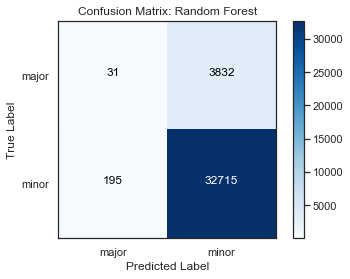

In [29]:
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

print("Train:", rf.score(X_train, y_train))
print("Test:", rf.score(X_test, y_test))

rf_y_preds_train = rf.predict(X_train)
print(classification_report(y_train, rf_y_preds_train, target_names=['major', 'minor']))

rf_y_preds_test = rf.predict(X_test)
print(classification_report(y_test, rf_y_preds_test, target_names=['major', 'minor']))

plot_cf(y_test, rf_y_preds_test, model_name='Random Forest', class_names=['major', 'minor'])

Surprisingly the random forest model performs worse than the logistic regression model.

The graph of feature importances below show that:
- The biggest predictor of accident severity is population density
- AADF (Anual Average Daily Flw) of motor vehicles and bicycles are also very important
- Next important features are speed limit, if the road was dry
- Day of the week is more important than time of day or month

In [30]:
def plot_feature_importances(model, figsize=(6,14)):
    """Plots a graph of feature importances for a model"""
    ft_weights = pd.DataFrame(model.feature_importances_, columns=['weight'], index=X.columns)
    ft_weights.sort_values('weight', inplace=True)
    plt.figure(figsize=(6,14))
    plt.barh(ft_weights.index, ft_weights.weight, align='center') 
    plt.title("Feature importances", fontsize=14)
    plt.xlabel("Feature importance")
    plt.margins(y=0.01)
    plt.show()

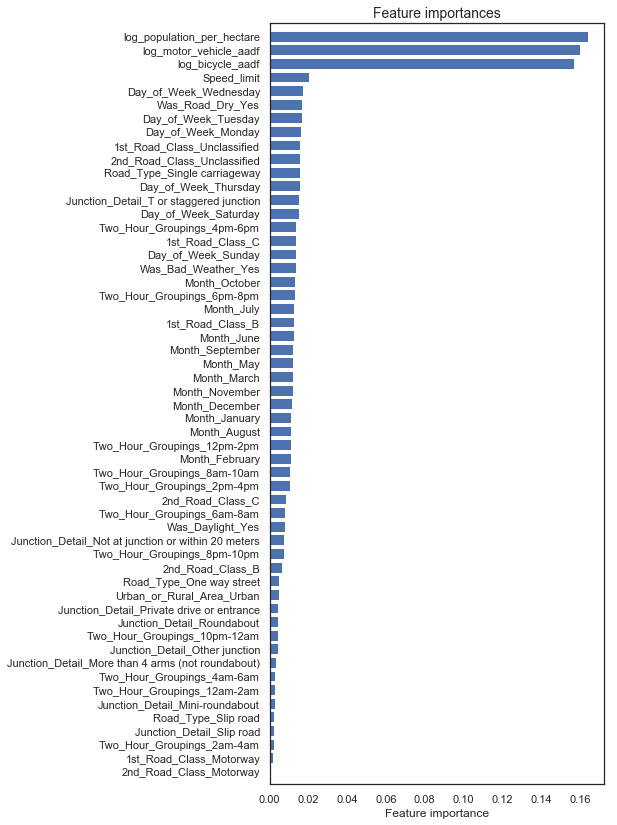

In [31]:
plot_feature_importances(rf)

### Model iteration 4: XGBoost
Next will try a different tree based model that has a good reputation of getting good results

Train: 0.571891316469813
Test: 0.6108557909335653
              precision    recall  f1-score   support

       major       0.58      0.51      0.54     98635
       minor       0.56      0.63      0.60     98635

   micro avg       0.57      0.57      0.57    197270
   macro avg       0.57      0.57      0.57    197270
weighted avg       0.57      0.57      0.57    197270

              precision    recall  f1-score   support

       major       0.13      0.47      0.20      3863
       minor       0.91      0.63      0.74     32910

   micro avg       0.61      0.61      0.61     36773
   macro avg       0.52      0.55      0.47     36773
weighted avg       0.83      0.61      0.69     36773



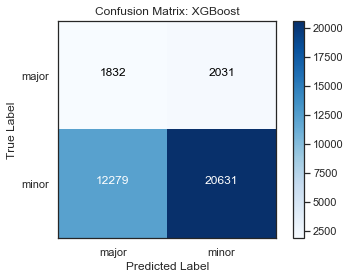

In [32]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

print("Train:", xgb.score(X_train, y_train))
print("Test:", xgb.score(X_test, y_test))

xgb_y_preds_train = xgb.predict(X_train)
print(classification_report(y_train, xgb_y_preds_train, target_names=['major', 'minor']))

xgb_y_preds_test = xgb.predict(X_test)
print(classification_report(y_test, xgb_y_preds_test, target_names=['major', 'minor']))

plot_cf(y_test, xgb_y_preds_test, model_name='XGBoost', class_names=['major', 'minor'])

XGBoost model performs much better overall than the Random Forest model.  Also XGBoost has slightly better recall than Logistic Regression but has almost identical results other wise.

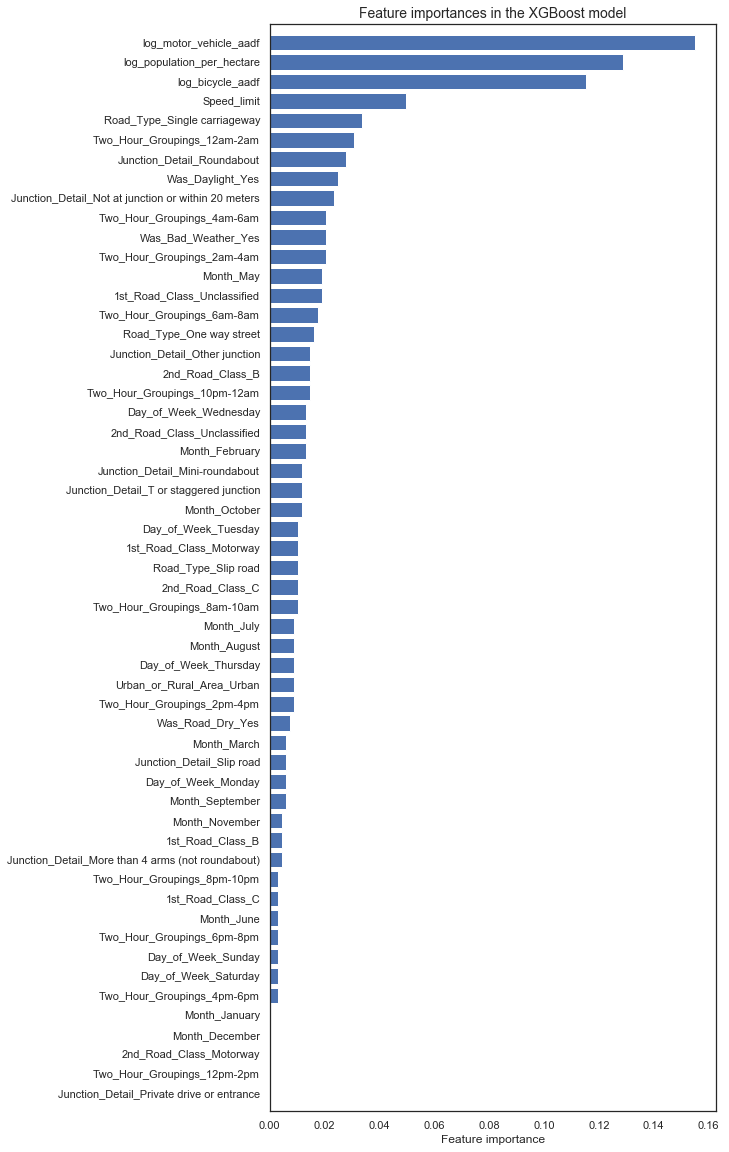

In [34]:
# Get feature importance from xgb model
ft_weights = pd.DataFrame(xgb.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights.sort_values('weight', inplace=True)

# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights.index, ft_weights.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

The top features for feature importance are the same, only differences are the next few important features are more about road type and time of day. 
<br>

Since it seems that XGBoost performs the best, let's see if we can try different sampling techniques to improve results.

The results below show the direction of the impact of the top features. Slight and serious accidents tend to occur in relatively similar circumstances. Fatal accidents occur more frequently:
- on roads with higher motor vehicle traffic and lower bicycle traffic
- in areas with lower population density

In [35]:
for col in ['log_population_per_hectare','log_bicycle_aadf', 'log_motor_vehicle_aadf']:
    print(np.exp(transformed_df.groupby('Accident_Severity')[col].median()))
    print("")

Accident_Severity
1    67.90000
2    61.54998
3    47.60000
Name: log_population_per_hectare, dtype: float64

Accident_Severity
1    185.600000
2    180.800000
3    128.599844
Name: log_bicycle_aadf, dtype: float64

Accident_Severity
1    18274.800000
2    18011.000000
3    20186.435323
Name: log_motor_vehicle_aadf, dtype: float64



### Model iteration 5: XGBoost using un even upsampling
Let's see how upsampling the minority class but still keeping a proportion of class imbalance affects our results.

In [37]:
# Splitting the data into train and test sets (automatically uses stratified sampling by labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

# concatenate our training data back together
training_data = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_safe = training_data[training_data.Accident_Severity==0]
safe = training_data[training_data.Accident_Severity==1]

# upsample minority
not_safe_upsampled = resample(not_safe,
                          replace=True, # sample with replacement
                          n_samples=int(len(safe)*.70), # 70% of majority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([safe, not_safe_upsampled])

# check new class counts
print(upsampled.Accident_Severity.value_counts())

X_train = upsampled.drop('Accident_Severity', axis=1)
y_train = upsampled.Accident_Severity

# Scaling X using StandardScaler
# Only fit training data to avoid data leakage
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=list(X_train.columns))
X_test = pd.DataFrame(scaler.transform(X_test), columns=list(X_test.columns))
X_train.head()

1    98635
0    69044
Name: Accident_Severity, dtype: int64


/Users/sabatinochen/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/sabatinochen/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/sabatinochen/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.


,Speed_limit,log_bicycle_aadf,log_population_per_hectare,Day_of_Week_Monday,Day_of_Week_Saturday,Day_of_Week_Sunday,Day_of_Week_Thursday,Day_of_Week_Tuesday,Day_of_Week_Wednesday,1st_Road_Class_B,1st_Road_Class_C,1st_Road_Class_Motorway,1st_Road_Class_Unclassified,Road_Type_One way street,Road_Type_Single carriageway,Road_Type_Slip road,Junction_Detail_Mini-roundabout,Junction_Detail_More than 4 arms (not roundabout),Junction_Detail_Not at junction or within 20 meters,Junction_Detail_Other junction,Junction_Detail_Private drive or entrance,Junction_Detail_Roundabout,Junction_Detail_Slip road,Junction_Detail_T or staggered junction,2nd_Road_Class_B,...,Two_Hour_Groupings_12am-2am,Two_Hour_Groupings_12pm-2pm,Two_Hour_Groupings_2am-4am,Two_Hour_Groupings_2pm-4pm,Two_Hour_Groupings_4am-6am,Two_Hour_Groupings_4pm-6pm,Two_Hour_Groupings_6am-8am,Two_Hour_Groupings_6pm-8pm,Two_Hour_Groupings_8am-10am,Two_Hour_Groupings_8pm-10pm,Was_Daylight_Yes,Was_Bad_Weather_Yes,Was_Road_Dry_Yes,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,log_motor_vehicle_aadf
0,-0.253822,-0.979059,-0.020365,2.492202,-0.392281,-0.351501,-0.421548,-0.418699,-0.424449,-0.317623,-0.358053,-0.182853,2.172759,-0.18959,0.578271,-0.105738,-0.124367,-0.117383,1.534094,-0.16229,-0.161378,-0.241507,-0.12454,-0.833807,-0.213851,...,-0.18495,-0.340457,-0.136475,-0.37129,-0.131752,-0.424468,-0.275562,-0.405270,2.705224,-0.292003,0.679186,-0.382322,0.490562,-0.288404,-0.300106,-0.274747,-0.291341,3.139510,-0.307739,-0.296371,-0.305889,-0.323989,-0.318203,-0.301908,-2.444713
1,-0.253822,1.086716,1.115159,-0.401252,-0.392281,2.844945,-0.421548,-0.418699,-0.424449,-0.317623,-0.358053,-0.182853,-0.460244,-0.18959,0.578271,-0.105738,-0.124367,-0.117383,-0.651850,-0.16229,-0.161378,-0.241507,-0.12454,1.199318,-0.213851,...,-0.18495,-0.340457,-0.136475,-0.37129,-0.131752,-0.424468,-0.275562,-0.405270,-0.369655,3.424620,-1.472352,-0.382322,0.490562,-0.288404,-0.300106,-0.274747,-0.291341,-0.318521,-0.307739,-0.296371,3.269158,-0.323989,-0.318203,-0.301908,0.361614
2,-0.253822,1.106610,0.793912,-0.401252,-0.392281,2.844945,-0.421548,-0.418699,-0.424449,-0.317623,2.792884,-0.182853,-0.460244,-0.18959,0.578271,-0.105738,-0.124367,-0.117383,-0.651850,-0.16229,-0.161378,-0.241507,-0.12454,-0.833807,-0.213851,...,-0.18495,-0.340457,-0.136475,-0.37129,-0.131752,-0.424468,-0.275562,2.467493,-0.369655,-0.292003,-1.472352,-0.382322,-2.038477,-0.288404,-0.300106,-0.274747,3.432402,-0.318521,-0.307739,-0.296371,-0.305889,-0.323989,-0.318203,-0.301908,-0.104198
3,-0.253822,0.506030,0.828492,-0.401252,-0.392281,-0.351501,-0.421548,-0.418699,2.355998,-0.317623,-0.358053,-0.182853,2.172759,-0.18959,0.578271,-0.105738,-0.124367,-0.117383,-0.651850,-0.16229,-0.161378,-0.241507,-0.12454,1.199318,-0.213851,...,-0.18495,2.937230,-0.136475,-0.37129,-0.131752,-0.424468,-0.275562,-0.405270,-0.369655,-0.292003,0.679186,-0.382322,0.490562,-0.288404,-0.300106,-0.274747,-0.291341,-0.318521,-0.307739,-0.296371,-0.305889,-0.323989,-0.318203,3.312263,0.331843
4,-0.253822,0.170545,-0.085652,-0.401252,-0.392281,-0.351501,-0.421548,-0.418699,2.355998,-0.317623,-0.358053,-0.182853,-0.460244,-0.18959,-1.729294,-0.105738,-0.124367,-0.117383,-0.651850,-0.16229,-0.161378,-0.241507,-0.12454,1.199318,-0.213851,...,-0.18495,-0.340457,-0.136475,-0.37129,-0.131752,-0.424468,-0.275562,-0.405270,2.705224,-0.292003,0.679186,-0.382322,0.490562,3.467362,-0.300106,-0.274747,-0.291341,-0.318521,-0.307739,-0.296371,-0.305889,-0.323989,-0.318203,-0.301908,0.201943


Train: 0.6059315716338958
Test: 0.8542680771218013
              precision    recall  f1-score   support

       major       0.60      0.13      0.21     69044
       minor       0.61      0.94      0.74     98635

   micro avg       0.61      0.61      0.61    167679
   macro avg       0.60      0.53      0.47    167679
weighted avg       0.61      0.61      0.52    167679

              precision    recall  f1-score   support

       major       0.18      0.11      0.13      3863
       minor       0.90      0.94      0.92     32910

   micro avg       0.85      0.85      0.85     36773
   macro avg       0.54      0.53      0.53     36773
weighted avg       0.82      0.85      0.84     36773



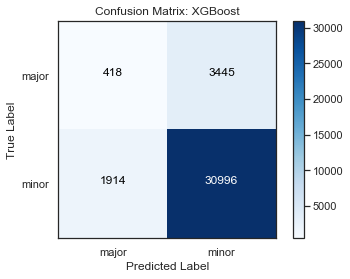

In [38]:
xgb2 = XGBClassifier(random_state=42)
xgb2.fit(X_train, y_train)

print("Train:", xgb2.score(X_train, y_train))
print("Test:", xgb2.score(X_test, y_test))

xgb2_y_preds_train = xgb2.predict(X_train)
print(classification_report(y_train, xgb2_y_preds_train, target_names=['major', 'minor']))

xgb2_y_preds_test = xgb2.predict(X_test)
print(classification_report(y_test, xgb2_y_preds_test, target_names=['major', 'minor']))

plot_cf(y_test, xgb2_y_preds_test, model_name='XGBoost', class_names=['major', 'minor'])

Using upsampling but not to the same amount as the majority class actually increases accuracy and precision. However, recall is much lower, and we have a lot more False Positives than False Negatives.

### Model iteration 6: XGBoost using MinMaxScaler
Now let's see if using a different scaler has any affect.

In [39]:
# Splitting the data into train and test sets (automatically uses stratified sampling by labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

# concatenate our training data back together
training_data = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_safe = training_data[training_data.Accident_Severity==0]
safe = training_data[training_data.Accident_Severity==1]

# upsample minority
not_safe_upsampled = resample(not_safe,
                          replace=True, # sample with replacement
                          n_samples=len(safe), # match number in majority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([safe, not_safe_upsampled])

# check new class counts
print(upsampled.Accident_Severity.value_counts())

X_train = upsampled.drop('Accident_Severity', axis=1)
y_train = upsampled.Accident_Severity

# Scaling X using MinMaxScaler
# Only fit training data to avoid data leakage
mm_scaler = MinMaxScaler()
X_train = pd.DataFrame(mm_scaler.fit_transform(X_train), columns=list(X_train.columns))
X_test = pd.DataFrame(mm_scaler.transform(X_test), columns=list(X_test.columns))
X_train.head()

1    98635
0    98635
Name: Accident_Severity, dtype: int64


/Users/sabatinochen/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Speed_limit,log_bicycle_aadf,log_population_per_hectare,Day_of_Week_Monday,Day_of_Week_Saturday,Day_of_Week_Sunday,Day_of_Week_Thursday,Day_of_Week_Tuesday,Day_of_Week_Wednesday,1st_Road_Class_B,1st_Road_Class_C,1st_Road_Class_Motorway,1st_Road_Class_Unclassified,Road_Type_One way street,Road_Type_Single carriageway,Road_Type_Slip road,Junction_Detail_Mini-roundabout,Junction_Detail_More than 4 arms (not roundabout),Junction_Detail_Not at junction or within 20 meters,Junction_Detail_Other junction,Junction_Detail_Private drive or entrance,Junction_Detail_Roundabout,Junction_Detail_Slip road,Junction_Detail_T or staggered junction,2nd_Road_Class_B,...,Two_Hour_Groupings_12am-2am,Two_Hour_Groupings_12pm-2pm,Two_Hour_Groupings_2am-4am,Two_Hour_Groupings_2pm-4pm,Two_Hour_Groupings_4am-6am,Two_Hour_Groupings_4pm-6pm,Two_Hour_Groupings_6am-8am,Two_Hour_Groupings_6pm-8pm,Two_Hour_Groupings_8am-10am,Two_Hour_Groupings_8pm-10pm,Was_Daylight_Yes,Was_Bad_Weather_Yes,Was_Road_Dry_Yes,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,log_motor_vehicle_aadf
0,0.2,0.439770,0.628489,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.318782
1,0.2,0.846664,0.821252,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.725036
2,0.2,0.850582,0.766718,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.657603
3,0.2,0.732287,0.772588,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.720726
4,0.2,0.666207,0.617406,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.701922


Train: 0.571891316469813
Test: 0.6108557909335653
              precision    recall  f1-score   support

       major       0.58      0.51      0.54     98635
       minor       0.56      0.63      0.60     98635

   micro avg       0.57      0.57      0.57    197270
   macro avg       0.57      0.57      0.57    197270
weighted avg       0.57      0.57      0.57    197270

              precision    recall  f1-score   support

       major       0.13      0.47      0.20      3863
       minor       0.91      0.63      0.74     32910

   micro avg       0.61      0.61      0.61     36773
   macro avg       0.52      0.55      0.47     36773
weighted avg       0.83      0.61      0.69     36773



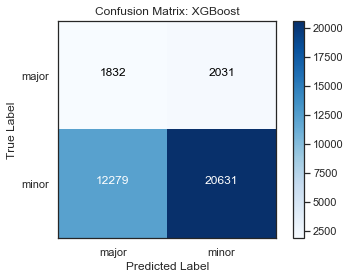

In [40]:
xgb3 = XGBClassifier(random_state=42)
xgb3.fit(X_train, y_train)

print("Train:", xgb3.score(X_train, y_train))
print("Test:", xgb3.score(X_test, y_test))

xgb3_y_preds_train = xgb3.predict(X_train)
print(classification_report(y_train, xgb3_y_preds_train, target_names=['major', 'minor']))

xgb3_y_preds_test = xgb3.predict(X_test)
print(classification_report(y_test, xgb3_y_preds_test, target_names=['major', 'minor']))

plot_cf(y_test, xgb3_y_preds_test, model_name='XGBoost', class_names=['major', 'minor'])

These results using MinMaxScaler actually produce identical results to the same model but using StandardScaler.

### Model iteration 7: XGBoost using down sampling

In [41]:
# Splitting the data into train and test sets (automatically uses stratified sampling by labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

# concatenate our training data back together
training_data = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_safe = training_data[training_data.Accident_Severity==0]
safe = training_data[training_data.Accident_Severity==1]

# upsample minority
safe_downsampled = resample(safe,
                          replace=True, # sample with replacement
                          n_samples=len(not_safe), # match number in minority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
downsampled = pd.concat([safe_downsampled, not_safe])

# check new class counts
print(downsampled.Accident_Severity.value_counts())

X_train = downsampled.drop('Accident_Severity', axis=1)
y_train = downsampled.Accident_Severity

# Scaling X using StandardScaler
# Only fit training data to avoid data leakage
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=list(X_train.columns))
X_test = pd.DataFrame(scaler.transform(X_test), columns=list(X_test.columns))
X_train.head()

1    11681
0    11681
Name: Accident_Severity, dtype: int64


/Users/sabatinochen/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/sabatinochen/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/sabatinochen/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.


,Speed_limit,log_bicycle_aadf,log_population_per_hectare,Day_of_Week_Monday,Day_of_Week_Saturday,Day_of_Week_Sunday,Day_of_Week_Thursday,Day_of_Week_Tuesday,Day_of_Week_Wednesday,1st_Road_Class_B,1st_Road_Class_C,1st_Road_Class_Motorway,1st_Road_Class_Unclassified,Road_Type_One way street,Road_Type_Single carriageway,Road_Type_Slip road,Junction_Detail_Mini-roundabout,Junction_Detail_More than 4 arms (not roundabout),Junction_Detail_Not at junction or within 20 meters,Junction_Detail_Other junction,Junction_Detail_Private drive or entrance,Junction_Detail_Roundabout,Junction_Detail_Slip road,Junction_Detail_T or staggered junction,2nd_Road_Class_B,...,Two_Hour_Groupings_12am-2am,Two_Hour_Groupings_12pm-2pm,Two_Hour_Groupings_2am-4am,Two_Hour_Groupings_2pm-4pm,Two_Hour_Groupings_4am-6am,Two_Hour_Groupings_4pm-6pm,Two_Hour_Groupings_6am-8am,Two_Hour_Groupings_6pm-8pm,Two_Hour_Groupings_8am-10am,Two_Hour_Groupings_8pm-10pm,Was_Daylight_Yes,Was_Bad_Weather_Yes,Was_Road_Dry_Yes,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,log_motor_vehicle_aadf
0,-0.258574,0.900690,0.935493,-0.393834,-0.384280,-0.351652,-0.422247,2.358466,-0.43017,-0.31853,-0.355559,-0.185111,-0.462112,-0.189639,0.577186,-0.10588,-0.124395,-0.122429,-0.662496,-0.160121,-0.162357,-0.237057,-0.12404,-0.828873,-0.208915,...,-0.190606,-0.342439,-0.138066,-0.372602,-0.132989,-0.422176,-0.279695,-0.397379,-0.366317,-0.291789,-1.466941,-0.380678,0.490726,-0.286312,-0.296855,-0.270604,-0.294373,3.163768,-0.313039,-0.296514,-0.307734,-0.326939,-0.315013,-0.298219,-0.004145
1,-0.258574,-0.906508,0.471032,-0.393834,-0.384280,-0.351652,2.368284,-0.424005,-0.43017,-0.31853,-0.355559,-0.185111,2.163978,-0.189639,0.577186,-0.10588,-0.124395,-0.122429,-0.662496,-0.160121,-0.162357,-0.237057,-0.12404,-0.828873,-0.208915,...,-0.190606,-0.342439,-0.138066,-0.372602,-0.132989,2.368679,-0.279695,-0.397379,-0.366317,-0.291789,0.681691,-0.380678,0.490726,-0.286312,-0.296855,-0.270604,-0.294373,-0.316079,-0.313039,-0.296514,-0.307734,-0.326939,-0.315013,-0.298219,-2.048665
2,-0.258574,-0.135070,-2.471401,-0.393834,2.602266,-0.351652,-0.422247,-0.424005,-0.43017,-0.31853,2.812471,-0.185111,-0.462112,-0.189639,0.577186,-0.10588,-0.124395,-0.122429,1.509443,-0.160121,-0.162357,-0.237057,-0.12404,-0.828873,-0.208915,...,-0.190606,-0.342439,-0.138066,-0.372602,-0.132989,2.368679,-0.279695,-0.397379,-0.366317,-0.291789,0.681691,-0.380678,-2.037799,-0.286312,-0.296855,-0.270604,3.397056,-0.316079,-0.313039,-0.296514,-0.307734,-0.326939,-0.315013,-0.298219,0.379337
3,-0.258574,0.889516,0.364017,-0.393834,-0.384280,-0.351652,-0.422247,-0.424005,-0.43017,-0.31853,-0.355559,-0.185111,2.163978,-0.189639,0.577186,-0.10588,-0.124395,-0.122429,1.509443,-0.160121,-0.162357,-0.237057,-0.12404,-0.828873,-0.208915,...,-0.190606,2.920228,-0.138066,-0.372602,-0.132989,-0.422176,-0.279695,-0.397379,-0.366317,-0.291789,0.681691,-0.380678,0.490726,-0.286312,-0.296855,-0.270604,-0.294373,3.163768,-0.313039,-0.296514,-0.307734,-0.326939,-0.315013,-0.298219,0.390370
4,-0.258574,-2.587014,-1.420174,-0.393834,-0.384280,-0.351652,2.368284,-0.424005,-0.43017,-0.31853,-0.355559,-0.185111,2.163978,-0.189639,0.577186,-0.10588,-0.124395,-0.122429,-0.662496,-0.160121,6.159275,-0.237057,-0.12404,-0.828873,-0.208915,...,-0.190606,-0.342439,-0.138066,-0.372602,-0.132989,-0.422176,-0.279695,2.516487,-0.366317,-0.291789,-1.466941,-0.380678,0.490726,-0.286312,-0.296855,-0.270604,-0.294373,-0.316079,-0.313039,3.372527,-0.307734,-0.326939,-0.315013,-0.298219,1.415550


Train: 0.5856947179179864
Test: 0.5779512142060751
              precision    recall  f1-score   support

       major       0.59      0.54      0.57     11681
       minor       0.58      0.63      0.60     11681

   micro avg       0.59      0.59      0.59     23362
   macro avg       0.59      0.59      0.58     23362
weighted avg       0.59      0.59      0.58     23362

              precision    recall  f1-score   support

       major       0.13      0.51      0.20      3863
       minor       0.91      0.59      0.71     32910

   micro avg       0.58      0.58      0.58     36773
   macro avg       0.52      0.55      0.46     36773
weighted avg       0.83      0.58      0.66     36773



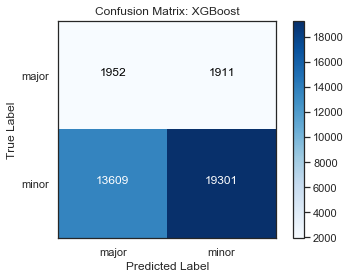

In [42]:
xgb4 = XGBClassifier(random_state=42)
xgb4.fit(X_train, y_train)

print("Train:", xgb4.score(X_train, y_train))
print("Test:", xgb4.score(X_test, y_test))

xgb4_y_preds_train = xgb4.predict(X_train)
print(classification_report(y_train, xgb4_y_preds_train, target_names=['major', 'minor']))

xgb4_y_preds_test = xgb4.predict(X_test)
print(classification_report(y_test, xgb4_y_preds_test, target_names=['major', 'minor']))

plot_cf(y_test, xgb4_y_preds_test, model_name='XGBoost', class_names=['major', 'minor'])

This is interesting, using downsampling lowers accuracy, but that isn't the metric we are trying to improve.  Recall actually improves very slightly which is what we want.  The downside to downsampling though compared to upsampling is that since we are using less data, there is more information loss.

### Model iteration 8: XGBoost with downsampling using top features

In [31]:
transformed_df.columns

Index(['Accident_Severity', 'Speed_limit', 'log_bicycle_aadf',
       'log_population_per_hectare', 'Day_of_Week_Monday',
       'Day_of_Week_Saturday', 'Day_of_Week_Sunday', 'Day_of_Week_Thursday',
       'Day_of_Week_Tuesday', 'Day_of_Week_Wednesday', '1st_Road_Class_B',
       '1st_Road_Class_C', '1st_Road_Class_Motorway',
       '1st_Road_Class_Unclassified', 'Road_Type_One way street',
       'Road_Type_Single carriageway', 'Road_Type_Slip road',
       'Junction_Detail_Mini-roundabout',
       'Junction_Detail_More than 4 arms (not roundabout)',
       'Junction_Detail_Not at junction or within 20 meters',
       'Junction_Detail_Other junction',
       'Junction_Detail_Private drive or entrance',
       'Junction_Detail_Roundabout', 'Junction_Detail_Slip road',
       'Junction_Detail_T or staggered junction', '2nd_Road_Class_B',
       '2nd_Road_Class_C', '2nd_Road_Class_Motorway',
       '2nd_Road_Class_Unclassified', 'Urban_or_Rural_Area_Urban',
       'Two_Hour_Groupings_10p

In [41]:
# Get just top features
X = transformed_df[['log_motor_vehicle_aadf', 'log_bicycle_aadf', 'log_population_per_hectare']]

In [42]:
# Splitting the data into train and test sets (automatically uses stratified sampling by labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

# concatenate our training data back together
training_data = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_safe = training_data[training_data.Accident_Severity==0]
safe = training_data[training_data.Accident_Severity==1]

# upsample minority
safe_downsampled = resample(safe,
                          replace=True, # sample with replacement
                          n_samples=len(not_safe), # match number in minority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
downsampled = pd.concat([safe_downsampled, not_safe])

# check new class counts
print(downsampled.Accident_Severity.value_counts())

X_train = downsampled.drop('Accident_Severity', axis=1)
y_train = downsampled.Accident_Severity

# Scaling X using StandardScaler
# Only fit training data to avoid data leakage
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=list(X_train.columns))
X_test = pd.DataFrame(scaler.transform(X_test), columns=list(X_test.columns))
X_train.head()

1    11681
0    11681
Name: Accident_Severity, dtype: int64


,log_motor_vehicle_aadf,log_bicycle_aadf,log_population_per_hectare
0,-0.004145,0.900690,0.935493
1,-2.048665,-0.906508,0.471032
2,0.379337,-0.135070,-2.471401
3,0.390370,0.889516,0.364017
4,1.415550,-2.587014,-1.420174


Train: 0.561595753788203
Test: 0.5854839148288146
              precision    recall  f1-score   support

       major       0.57      0.48      0.52     11681
       minor       0.55      0.64      0.59     11681

   micro avg       0.56      0.56      0.56     23362
   macro avg       0.56      0.56      0.56     23362
weighted avg       0.56      0.56      0.56     23362

              precision    recall  f1-score   support

       major       0.12      0.45      0.19      3863
       minor       0.90      0.60      0.72     32910

   micro avg       0.59      0.59      0.59     36773
   macro avg       0.51      0.53      0.45     36773
weighted avg       0.82      0.59      0.67     36773



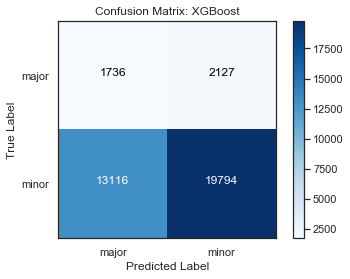

In [43]:
xgb5 = XGBClassifier(random_state=42)
xgb5.fit(X_train, y_train)

print("Train:", xgb5.score(X_train, y_train))
print("Test:", xgb5.score(X_test, y_test))

xgb5_y_preds_train = xgb5.predict(X_train)
print(classification_report(y_train, xgb5_y_preds_train, target_names=['major', 'minor']))

xgb5_y_preds_test = xgb5.predict(X_test)
print(classification_report(y_test, xgb5_y_preds_test, target_names=['major', 'minor']))

plot_cf(y_test, xgb5_y_preds_test, model_name='XGBoost', class_names=['major', 'minor'])

This model using just the most important features performs slightly worse but is overall a more simple model. 

## Conclusion

The best performing models seem to be using XGBoost with either upsampling the minority class or downsampling the majority class. Because the downsampling model has slightly better recall with regards to major accidents, that might be the better model. Further hyperparameter tuning on this model can be done to improve results.  Also since this is mainly an imbalance issue, possibly experimenting with different class weights or probablity thresholds could help deal with this issue. Using the top features got similar but lower results when using the XGBoost with undersampling but is a much simpler model.
<br>

This can be left for future work, but for now we will move on to our next model in this project, where we will see if we can use satellite images to predict which areas of London have traffic accidents.